Course: https://www.udemy.com/course/time-series-analysis/

# Section 5: ARIMA

- ARIMA stands for Autoregressive Integrated Moving Average
- The data for this course is available at: https://docs.google.com/document/d/1SiG1V325FQ4bqhUFEoXGhkAK89RSS0tplcJBCuivn_s/edit?usp=sharing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ARIMA in Code

- Analyze airline passengers data using ARIMA model

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File 'airline_passengers.csv' already there; not retrieving.



In [3]:
df = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


- Look at time plot:

<Figure size 640x480 with 0 Axes>

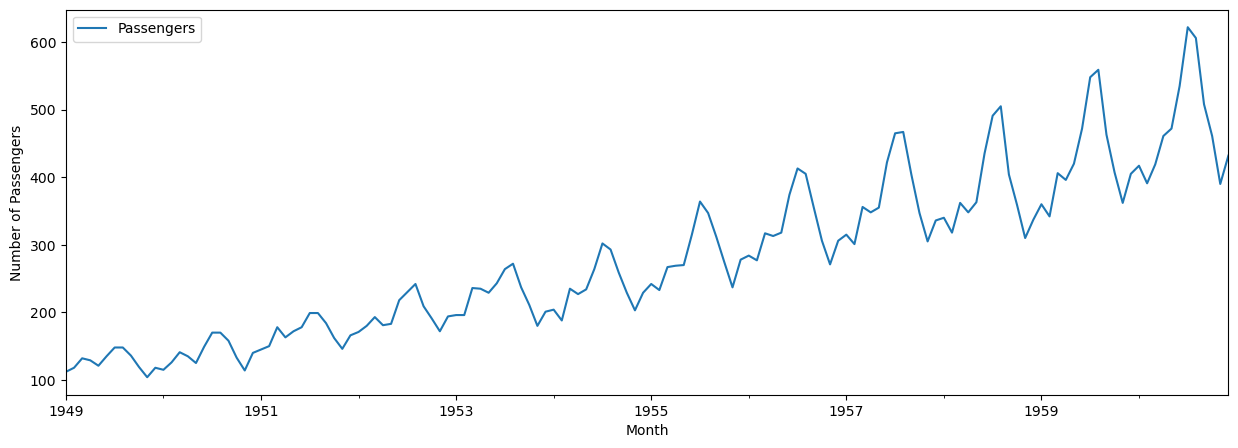

In [4]:
plt.figure()
df.plot(figsize=(15,5))
plt.ylabel('Number of Passengers')
plt.show()

- Now calculate the difference of number of passengers:

In [5]:
df['Passengers'].diff() # default period to shift is 1, compare to above

Month
1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
              ... 
1960-08-01   -16.0
1960-09-01   -98.0
1960-10-01   -47.0
1960-11-01   -71.0
1960-12-01    42.0
Name: Passengers, Length: 144, dtype: float64

In [6]:
df['1stdiff'] = df['Passengers'].diff() # now save the first difference

- Replot to see 1st difference and original:
    - Note has the trend has dissapeared
    - However, 1st diff is not quite stationary since there is still seasonality (e.g. lowest throughs near end of year followed by spikes) and variance (amplitude change) is increasing over time

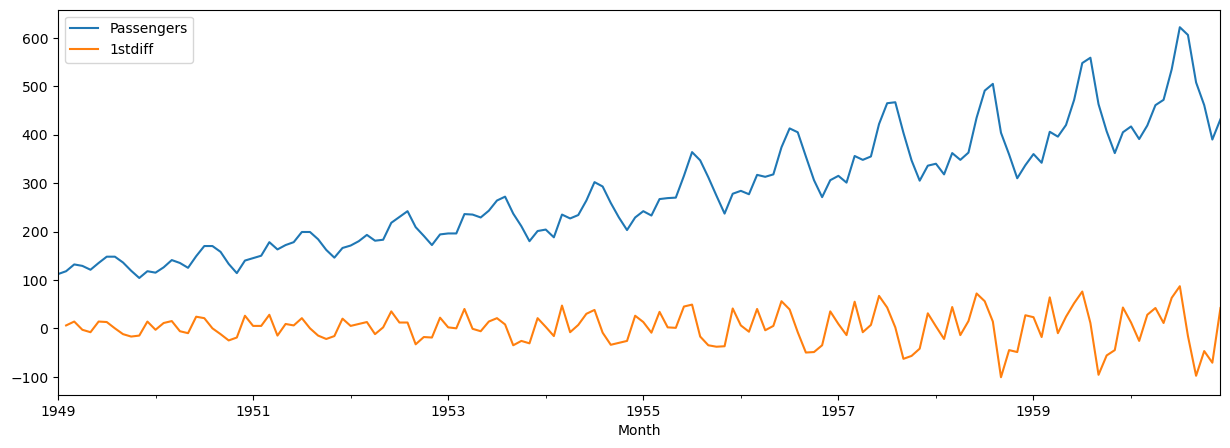

In [7]:
df.plot(figsize=(15,5))
plt.show()

- To make it stationary let's try taking the log of the time series. This should fix the changing variance:
    - Notice how the values don't seem to be growing as rapidly as in the original time series
    - Furthermore, amplitude of cycles looks more constant than before

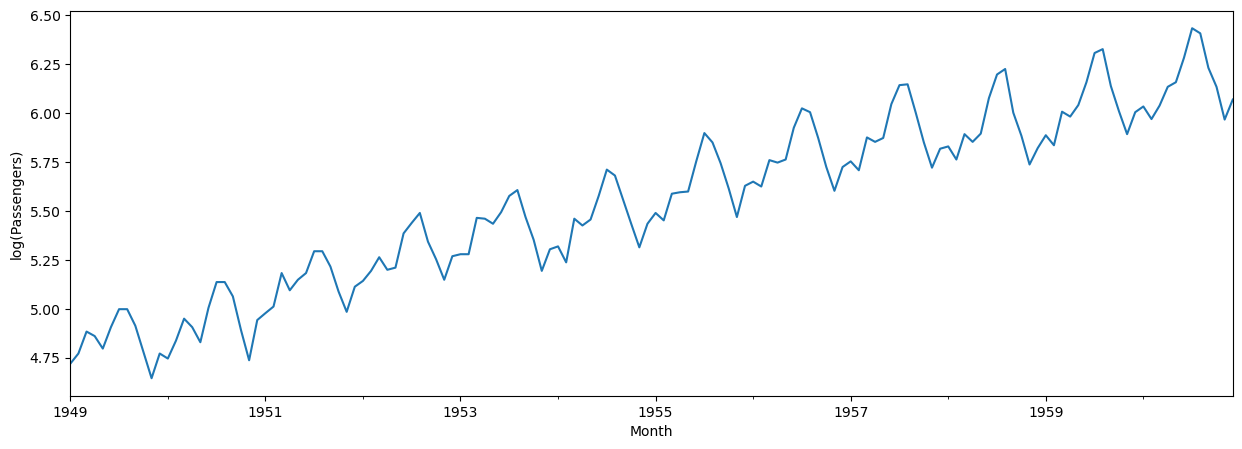

In [8]:
df['LogPassengers'] = df['Passengers'].apply(np.log)

# plot
df['LogPassengers'].plot(figsize=(15,5))
plt.ylabel('log(Passengers)')
plt.show()

- Moving onto ARIMA, let's prepare the train/test split in data:

In [9]:
df.index.freq = 'MS' # as in previous notebooks, set the frequency explicitly to monthly

Ntest = 12 # use latest 12 months as test data
train = df.iloc[:-Ntest] # split train and test data
test = df.iloc[-Ntest:]

train_idx = df.index <= train.index[-1] # save train and test indices for later use
test_idx = df.index > train.index[-1]

- Import ARIMA model from statsmodel and fit to instructor-specified model over training set:
    - We will use the ARIMA(1,0,0) = AR(1) model
        - In this model, the current value in time series depends linearly on just the previous value

In [10]:
from statsmodels.tsa.arima.model import ARIMA

In [11]:
arima = ARIMA(train['Passengers'],order=(1,0,0)) # instantiate model, with p=1, d=0, and q=0

arima_result = arima.fit() # fit the model
                           # returns an ARIMAResults object, not a model

- Now validate by _predicting_ over the time covered by the training data:
    - Note how AR(1) gives a "delayed" behavior similar to what we saw in Holt-Winters when model was mispecified 
    - Seems the best the model can do is just copy the previous value, or close to it

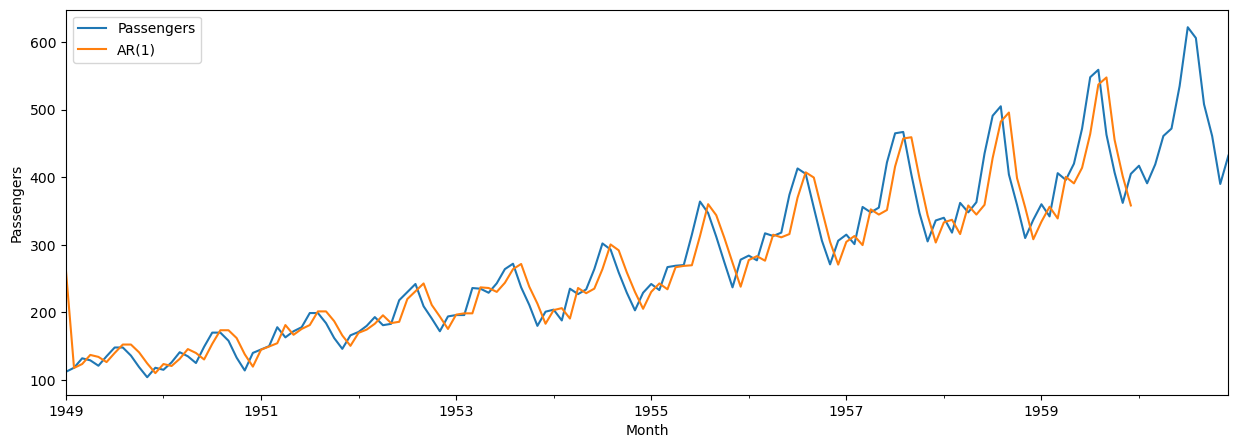

In [12]:
df.loc[train_idx,'AR(1)'] = arima_result.predict(start=train.index[0],end=train.index[-1])

# plot original and predictions
df[['Passengers','AR(1)']].plot(figsize=(15,5))
plt.ylabel('Passengers')
plt.show()

- Now _forecast_ over the timeline covered by the test set and plot:
    - Note that `forecast` function would give only out-of-sample forecasts while `get_forecast` gives out-of-sample forecasts and prediction intervals
    - As we can see in the plot, this AR(1) model is not very good and does not even capture the trend. Even the naive forecast would be better

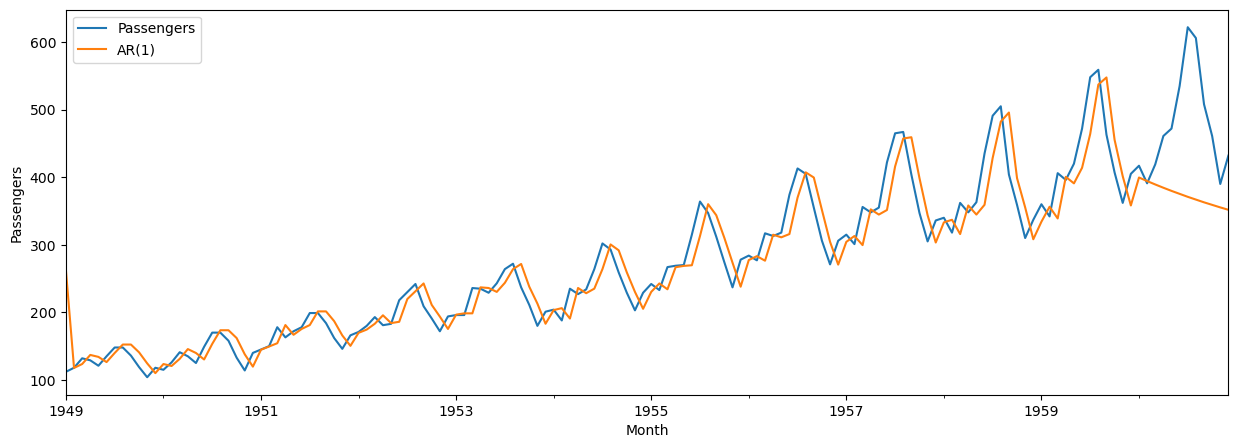

In [13]:
prediction_result = arima_result.get_forecast(Ntest) # returns type PredictionResults
forecast = prediction_result.predicted_mean
df.loc[test_idx,'AR(1)'] = forecast

# plot
df[['Passengers','AR(1)']].plot(figsize=(15,5))
plt.ylabel('Passengers')
plt.show()

In [14]:
prediction_result.conf_int(alpha=0.05).head() # returns confidence intervals of alpha value
                                              # alpha = 0.05 is actually the default

,lower Passengers,upper Passengers
1960-01-01,338.658210,460.451500
1960-02-01,309.826172,478.809354
1960-03-01,287.732169,490.829379
1960-04-01,269.338256,499.534230
1960-05-01,253.432284,506.121347


- Since the prediction_result type is a wrapper around PredictionResults, any method within PredictionResults object probably also belongs to this object

In [15]:
type(prediction_result)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

- Let's plot it all together so far: time series, ARIMA model, and its forecast confidence intervals
    - As instructor points out, we will use this bit over again later so make it into a function

In [16]:
def plot_fit_and_forecast(arima_result):
    
    # plot original time series
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(df['Passengers'],label='data')
    
    # plot curve fitted on train set
    train_pred = arima_result.fittedvalues
    ax.plot(train.index,train_pred,c='g',label='fitted')
    
    # forecast the test set and plot alongside 95% confidence intervals
    prediction_result = arima_result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int() # default alpha = 0.05
    lower, upper = conf_int['lower Passengers'], conf_int['upper Passengers']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index,forecast,label='forecast')
    ax.fill_between(test.index,lower,upper,color='r',alpha=0.3,label='95% C.I.')
    
    ax.legend()

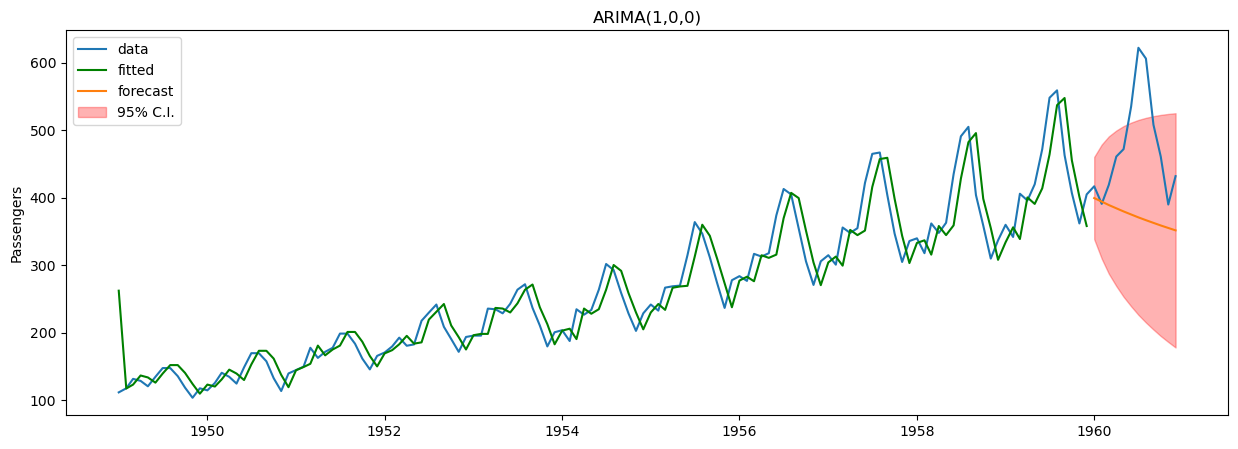

In [17]:
plot_fit_and_forecast(arima_result)
plt.title('ARIMA(1,0,0)')
plt.ylabel('Passengers')
plt.show()

- Again, we see that this AR(1) forecast is not very good
- Next let's try adding more inputs by using an AR(10) model:

C:\Users\14047\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\14047\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


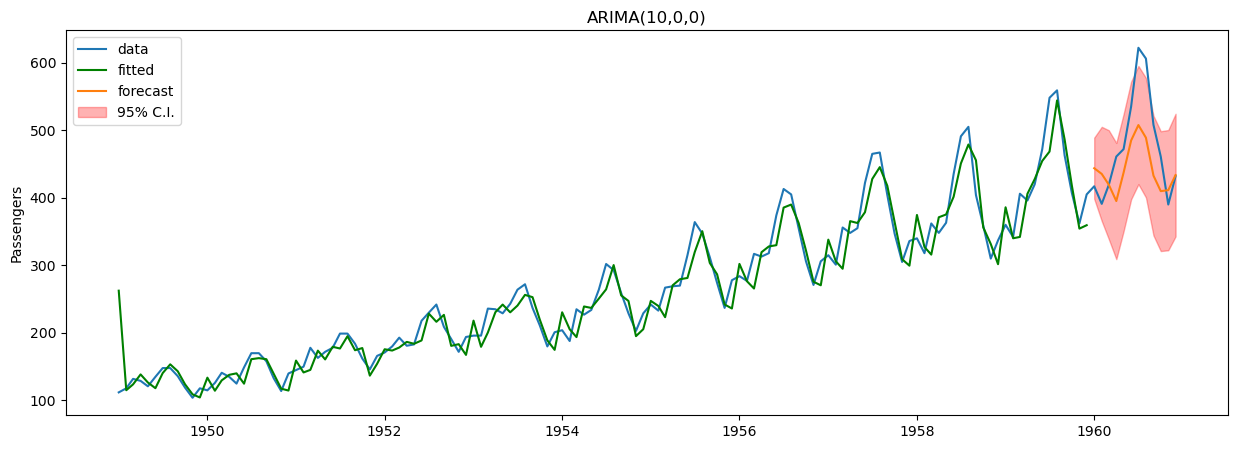

In [18]:
arima = ARIMA(train['Passengers'],order=(10,0,0))
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)
plt.title('ARIMA(10,0,0)')
plt.ylabel('Passengers')
plt.show()

- We see that this does a better job:
    - It doesn't lag. Model is starting to learn to anticipate the pattern rather than just copying the last value. This is due to the increased window size in lookback 1 -> 10
    - In forecast, model does learn that signal is periodic. However, it underestimates the true value siginificantly
- Next, test an MA(1) = ARIMA(0,0,1) model:

C:\Users\14047\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


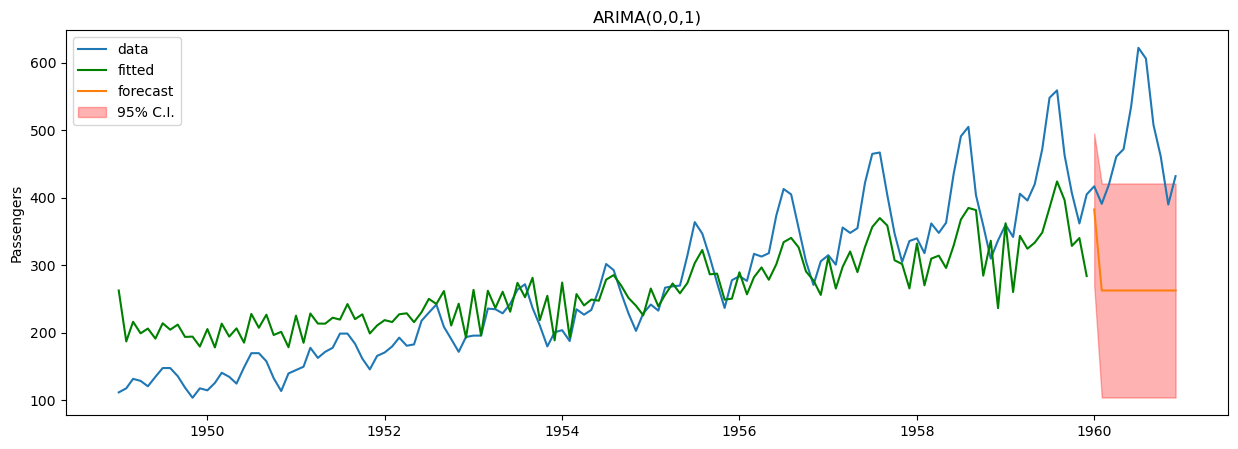

In [19]:
arima = ARIMA(train['Passengers'],order=(0,0,1))
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)
plt.title('ARIMA(0,0,1)')
plt.ylabel('Passengers')
plt.show()

- Looks pretty bad and worse than AR(1):
    - Recall that the moving average model forecast expexted value is always constant, thus, intuitively this is not a good choice here
- Next, investigate using the log(Passengers):
    - First, take the difference of logs

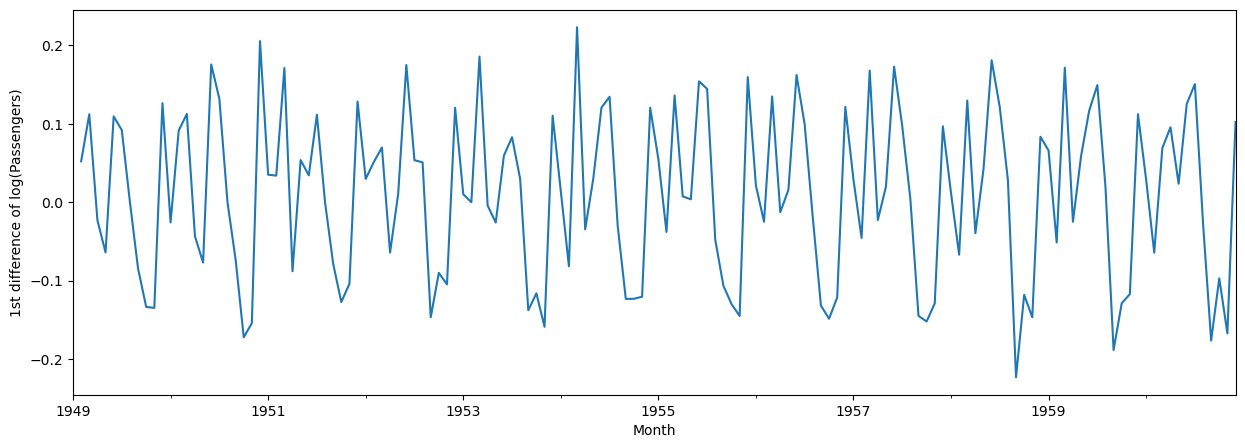

In [20]:
df['Log1stDiff'] = df['LogPassengers'].diff()

# plot
df['Log1stDiff'].plot(figsize=(15,5))
plt.ylabel('1st difference of log(Passengers)')
plt.show()

- The behavior is what we expected. Unlike the 1st difference of the non-log Passengers, the 1st difference of the log(Passengers) do not seem to grow much over time
- Before fitting an ARIMA model to the above series, let's go back and try a more complicated model on Passenger data
- This time we'll try an ARIMA(8,1,1) model:
    - p = 8 since we've seen using more past values helps
    - d = 1 since we've seen differencing helps remove the trend
    - q = 1 just to have a complete ARIMA model

In [21]:
arima = ARIMA(train['Passengers'],order=(8,1,1))
arima_result_811 = arima.fit()

- Now write a new plot function for the differenced (integrated) time series (d = 1):
    - We need to fix the previous plot function since the differenced time series has one less index

In [22]:
def plot_fit_and_forecast_int(result, d, col='Passengers'):
    '''
    result: ARIMAResults object
    d: first row in differenced time series
    col: which column of data frame to fit model on
    '''
    
    # plot original time series
    fig,ax = plt.subplots(figsize=(15,5))
    ax.plot(df[col],label='data')
    
    # plot the curve fitted on train set
    train_pred = result.predict(start=train.index[d],end=train.index[-1])
    ax.plot(train.index[d:],train_pred,c='g',label='fitted')
    
    # forecast the test set
    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower,upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index,lower,upper,color='red',alpha=0.3,label='95% C.I.')
    
    ax.legend()

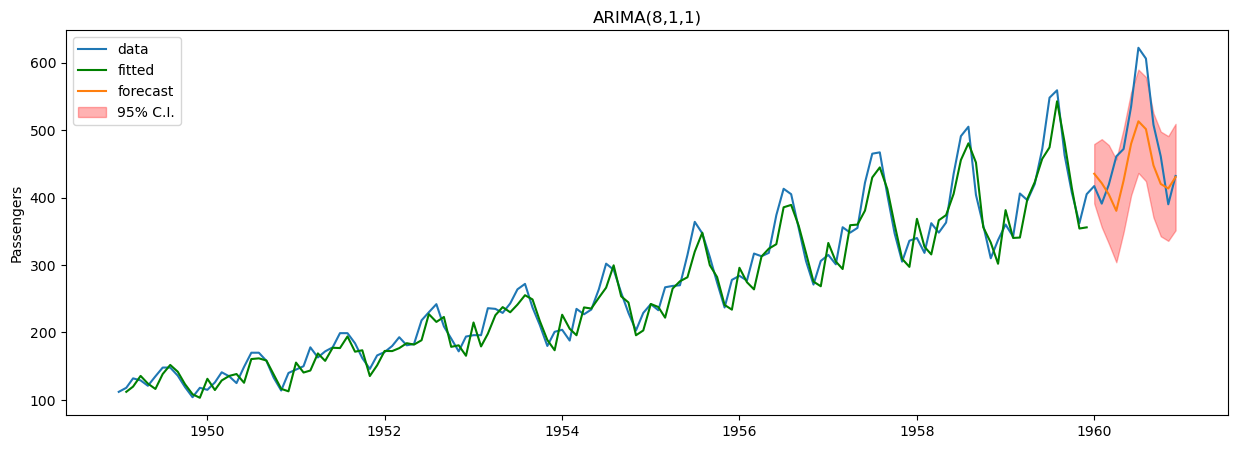

In [23]:
plot_fit_and_forecast_int(arima_result_811,1)
plt.ylabel('Passengers')
plt.title('ARIMA(8,1,1)')
plt.show()

- This full ARIMA model seems to be doing better although still underestimating the peak
- Now let's fit and plot the same ARIMA model to the log(Passengers):

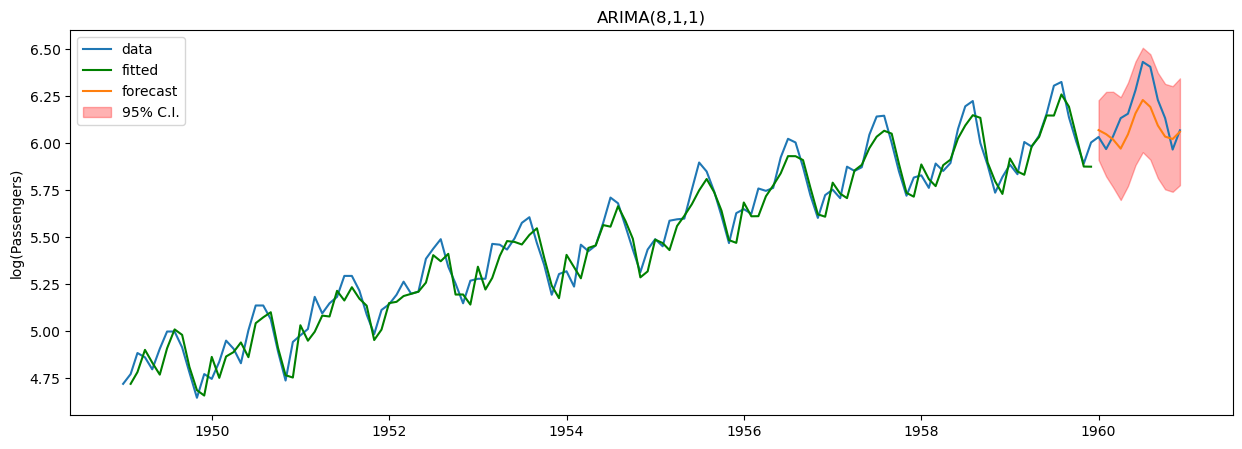

In [24]:
arima = ARIMA(train['LogPassengers'],order=(8,1,1))
arima_result_log811 = arima.fit()
plot_fit_and_forecast_int(arima_result_log811,1,col='LogPassengers')
plt.ylabel('log(Passengers)')
plt.title('ARIMA(8,1,1)')
plt.show()

- Doing decently well, it captures seasonality but still underestimates the peak. Seems to do a bit worse than non-log data
- What happens if we add more auto-regressive terms?
    - Switch p from 8 to 12: this would use data from all 12 months in the past year

C:\Users\14047\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\14047\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


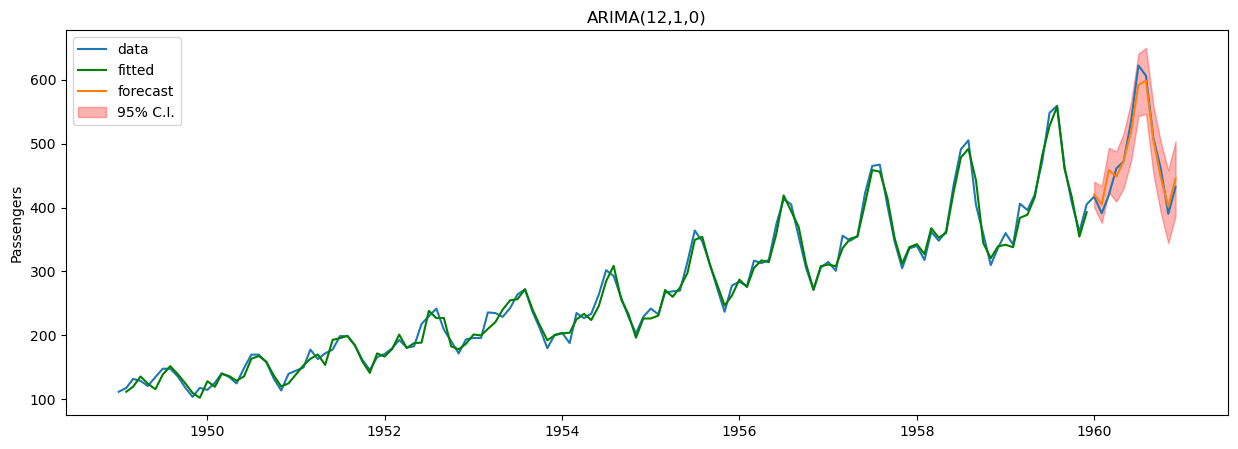

In [25]:
arima = ARIMA(train['Passengers'],order=(12,1,0))
arima_result_1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_1210,1)
plt.ylabel('Passengers')
plt.title('ARIMA(12,1,0)')
plt.show()

- This seems like the best model so far!
- Now let's try to fit the same model to the log(Passengers):

C:\Users\14047\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


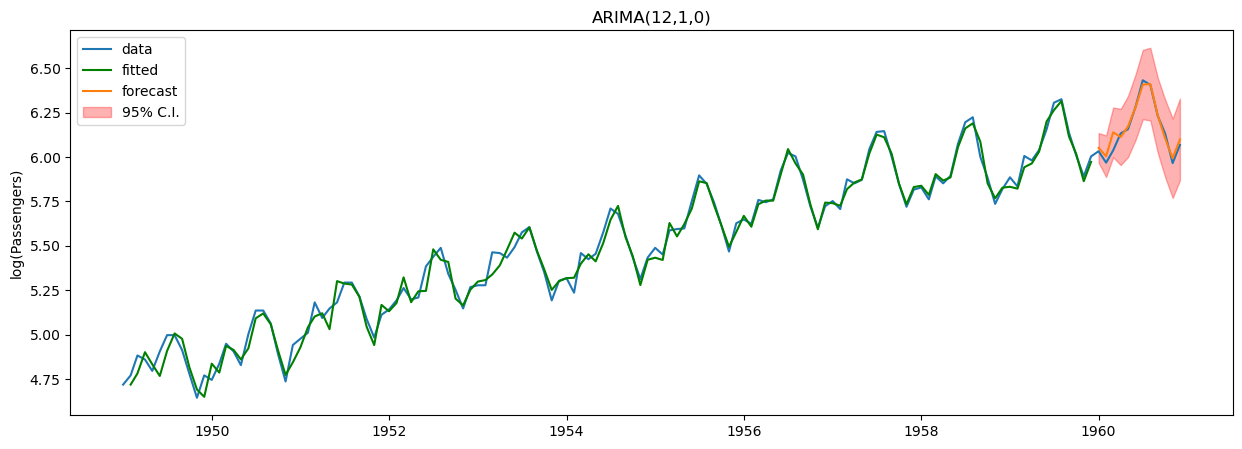

In [26]:
arima = ARIMA(train['LogPassengers'],order=(12,1,0))
arima_result_log1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_log1210,1,col='LogPassengers')
plt.ylabel('log(Passengers)')
plt.title('ARIMA(12,1,0)')
plt.show()

- This looks good too but hard to tell which one is better
- In order to quantitatively decide which is better we need a metric like the RMSE. Define the function:

In [27]:
def rmse(result,is_logged):
    '''
    result: ARIMAResults object
    is_logged: bool, whether logarithm transformation is applied to the data
    '''
    forecast = result.forecast(Ntest) # just forecast since confidence intervals not necessary 
    if is_logged: # if log used, we recover time series via exponentiation
        forecast = np.exp(forecast)
    
    t = test['Passengers']
    y = forecast
    return np.sqrt(np.mean((t-y)**2))

- Compare last two ARIMA model explored for original time series and logged versions:

In [28]:
print(f'ARIMA(8,1,1): {rmse(arima_result_811,False)}')
print(f'ARIMA(8,1,1) logged: {rmse(arima_result_log811,True)}')
print(f'ARIMA(12,1,0): {rmse(arima_result_1210,False)}')
print(f'ARIMA(12,1,0) logged: {rmse(arima_result_log1210,True)}')

ARIMA(8,1,1): 59.06458657739681
ARIMA(8,1,1) logged: 61.60410178699154
ARIMA(12,1,0): 17.483957583532877
ARIMA(12,1,0) logged: 16.115589657304067


- We see that:
    - Logging data was a bit worse for ARIMA(8,1,1)
    - Adding more lag values to the model does really help
    - Best model appears to be ARIMA(12,1,0) with logging

# Stationarity in Code

## Airline Passenger Data
- Apply ADF Test to a variety of datasets and see if it fits our intuition about what is stationary and what is not

In [29]:
from statsmodels.tsa.stattools import adfuller

In [30]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File 'airline_passengers.csv' already there; not retrieving.



- Load airline passengers dataset and plot
    - From plot we can see this data is not stationary: it has both a trend and a seasonal component

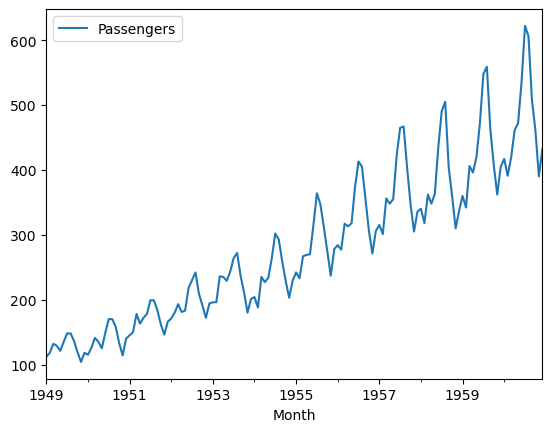

In [31]:
df = pd.read_csv('airline_passengers.csv', index_col='Month',parse_dates=True)
df.plot();

- Apply ADF Test (documentation: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) to Passenger data:
    - First two return values are test-statistics (adf, p-value)
    - Third is number of lags used and fourth is number of observations used
    - The dictionary contains critical values for the test statistic at the 1%, 5%, and 10% levels
    - Last is the maximized informatoin criterion

In [32]:
adfuller(df['Passengers'])

(0.8153688792060543,
 0.9918802434376411,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

- Write a helper function to print relevant result of adfuller function:

In [33]:
def adf(x):
    '''
    runs Adjusted Dickey-Fuller (ADF) test on x and prints out results
    '''
    res = adfuller(x)
    print(f'test-statistic (adf): {res[0]}')
    print(f'p-value: {res[1]}')
    if res[1] < 0.05: # assuming 95% CI
        print('Stationary')
    else:
        print('Non-stationary')

In [34]:
adf(df['Passengers'])

test-statistic (adf): 0.8153688792060543
p-value: 0.9918802434376411
Non-stationary


- Since $p=0.99 > 0.05$ then we cannot reject null hypothesis ($H_0$: time series is non-stationary)
- Now try ADF test on i.i.d noise samples from two stationary distributions:
    - Note that these are strong-sense stationary since entire distribution remains fixed over time

In [35]:
adf(np.random.randn(100))

test-statistic (adf): -3.650646359103381
p-value: 0.004863414263543373
Stationary


In [36]:
adf(np.random.gamma(1,1,100))

test-statistic (adf): -7.489037917088619
p-value: 4.557095598659247e-11
Stationary


- p-values are very small and << 0.05 so must reject $H_0$, i.e these are stationary
- Now test log(Passengers) with ADF:

In [37]:
df['LogPassengers'] = df['Passengers'].apply(np.log)

adf(df['LogPassengers'])

test-statistic (adf): -1.7170170891069625
p-value: 0.4223667747703904
Non-stationary


- Not surprisingly, result is still not stationary (see plot in previous section where the trend and seasonality are still visible)
    - Recall that the log transform is used to help stabilize the variance but it does not remove trends/seasonality
- Now try 1st-difference of Passengers with ADF:

In [38]:
df['Diff'] = df['Passengers'].diff()

adf(df['Diff'].dropna()) # drop null first value (which has no difference to compute by definition)

test-statistic (adf): -2.8292668241700034
p-value: 0.054213290283824954
Non-stationary


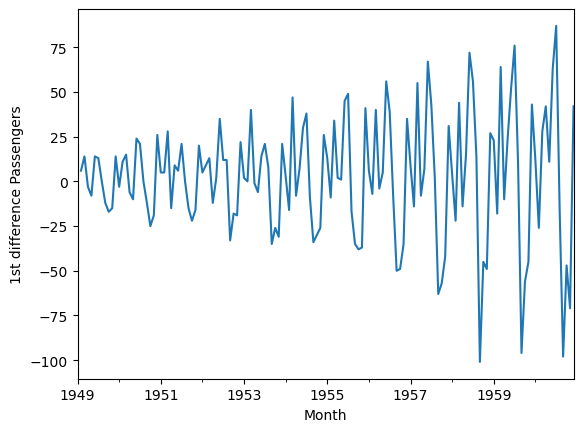

In [39]:
df['Diff'].plot()
plt.ylabel('1st difference Passengers')
plt.show()

- From the plot we can see that the variance of signal increases over time so makes sense (as non-stationary)
- However, notice how close the p-value is to 5%!
    - If we had lowered our significance to 10% we would have concluded that it is indeed stationary
- Finally test the 1st difference of log(Passengers) with ADF:

In [40]:
df['DiffLog'] = df['LogPassengers'].diff()

adf(df['DiffLog'].dropna())

test-statistic (adf): -2.7171305983881595
p-value: 0.07112054815085424
Non-stationary


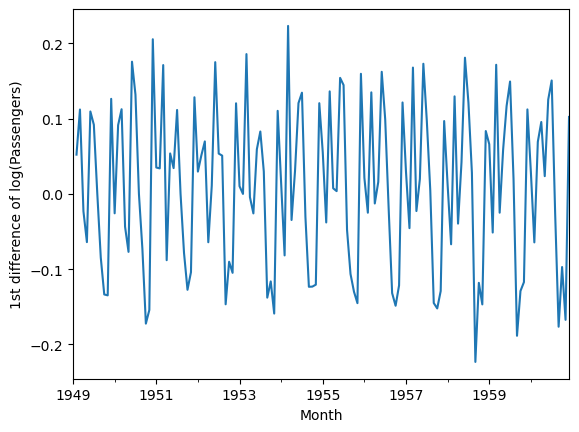

In [41]:
df['DiffLog'].plot()
plt.ylabel('1st difference of log(Passengers)')
plt.show()

- Surprisingly the p-value is higher than the one we got when the variance was increasing!
    - Instructor provides no further discussion of this result...

## Stock Price Data (SP500)
- Now move onto examining stock prices using the sp500 data:

In [42]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

File 'sp500sub.csv' already there; not retrieving.



In [43]:
stocks = pd.read_csv('sp500sub.csv', index_col='Date',parse_dates=True)
stocks.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


- Investigate the closing stock prices for Google
    - We'll look at log(Price), log(Return)

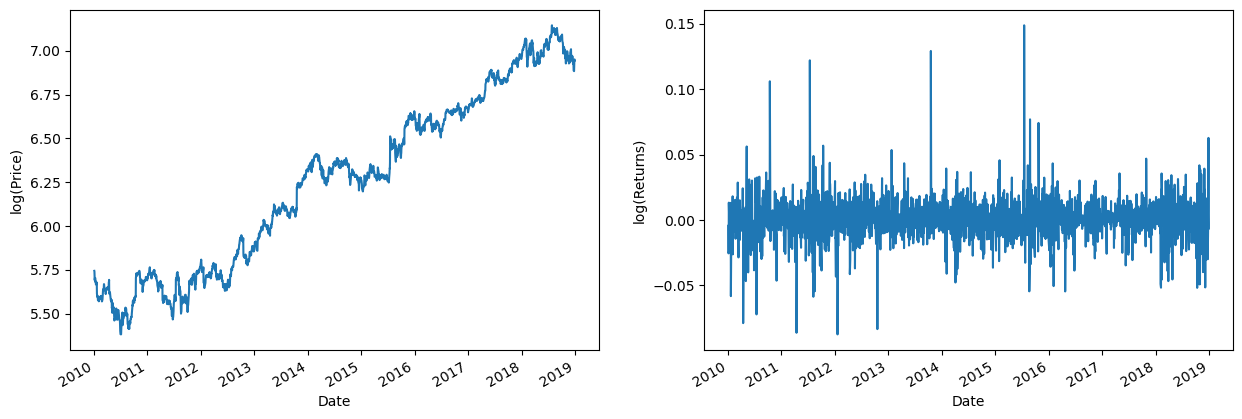

In [44]:
goog = stocks[stocks['Name']=='GOOG'][['Close']]
goog['LogPrice'] = goog['Close'].apply(np.log)
goog['LogRet'] = goog['LogPrice'].diff() # recall log(return) = p_t - p_{t-1}

# plot
plt.figure(figsize=(15,5))
plt.subplot(121)
goog['LogPrice'].plot();
plt.ylabel('log(Price)')
plt.subplot(122)
goog['LogRet'].plot();
plt.ylabel('log(Returns)')
plt.show()

- As we can see, the log(Price) has a clear trend whereas the log(Returns) seems stationary although the variance seems to increase in some places
- Run the ADF Test on both:

In [45]:
print('LogPrice:')
adf(goog['LogPrice'])

print('LogReturns:')
adf(goog['LogRet'].dropna())

LogPrice:
test-statistic (adf): -0.41819025789061154
p-value: 0.907017067749841
Non-stationary
LogReturns:
test-statistic (adf): -46.66748022773677
p-value: 0.0
Stationary


- Conclusion: log price is not-stationary while log returns is so stationary that p-value is rounded to 0
- Instructor replicates the above test on stocks for Starbucks. Omitting as uninstructive

# PACF and AR(p) in Code
- Will use PACF to help choose AR(p)

In [136]:
from statsmodels.graphics.tsaplots import plot_pacf

- Generate i.i.d noise from standard normal distribution:

Text(0.5, 0, '$t$')

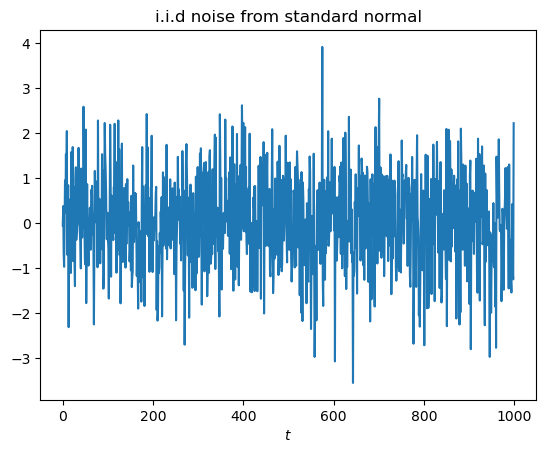

In [137]:
x0 = np.random.randn(1000)

plt.plot(x0);
plt.title('i.i.d noise from standard normal');
plt.xlabel(r'$t$')

- We'll be looking at autoregressive (AR) models first so plot PACF:
    - Recall that we expect the first value to be equal to 1 since that is just the autocorrelation of each point to itself
    - Note that there are also multiple values in which the PACF goes just outside the C.I. This is allowed to happen randomly 5% of the time (alpha = 0.05 default) even where there is no true correlation. Since these values are so close to the threshold, we can conclude that it's probably ok to ignore them

<Figure size 640x480 with 0 Axes>

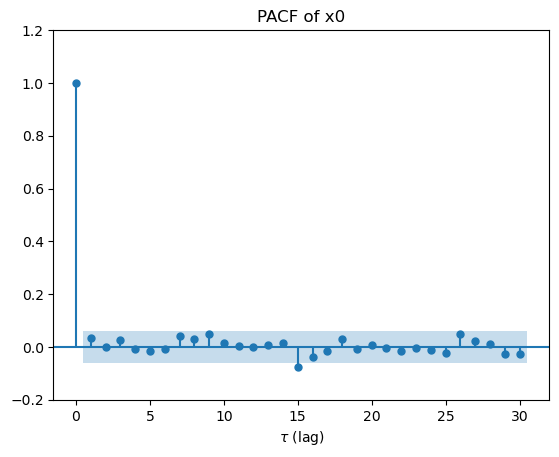

In [138]:
plt.figure()
plot_pacf(x0) # if lag parameter no specified then x axis goes like np.arange(len(corr))
plt.ylim(-0.2,1.2)
plt.title('PACF of x0')
plt.xlabel(r'$\tau$ (lag)')
plt.show()

- Now create an AR(1) process and plot the PACF again
    - The process is simulated by creating a series in which the next value depends on the previous value plus some noise
    - In the plot you can see that it looks pretty stationary and that there's no observable difference between this and i.i.d noise, i.e it's not obvious that each value depends on the previous value

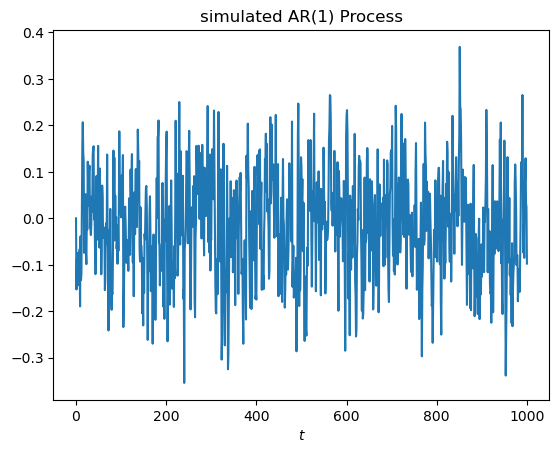

In [139]:
x1 = [0] # initialize ts

for i in range(1_000): # generate 1000 samples
    x = 0.5*x1[-1] + 0.1*np.random.randn() # value equal to 0.5*previous value + Gaussian noise with std. = 0.1
    x1.append(x)
    
x1 = np.asarray(x1) # transform to numpy array

# plot
plt.plot(x1);
plt.xlabel(r'$t$')
plt.title('simulated AR(1) Process');

- Now plot its PACF:
    - We have a PACF value at lag 1 which is far outside the C.I.
    - Just looking from this plot we would conclude that this is an AR(1) process, which we know to be true

<Figure size 640x480 with 0 Axes>

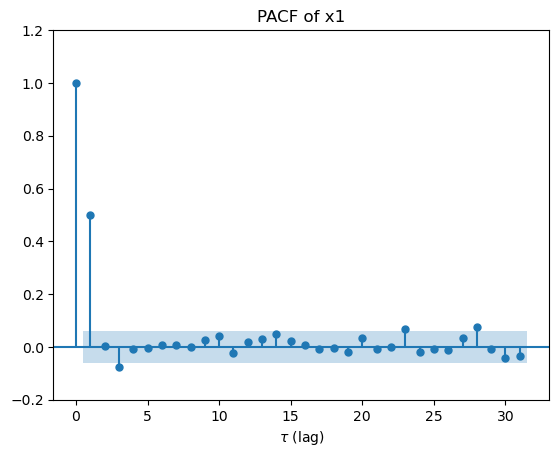

In [140]:
plt.figure()
plot_pacf(x1)
plt.ylim(-0.2,1.2)
plt.title('PACF of x1')
plt.xlabel(r'$\tau$ (lag)')
plt.show()

- As an experiment, change the simulated AR(1) process dependence to be negative on the previous value and re-examine the PACF plot:
    - The spike remains at lag 1 but this time it is negative, to reflect the negative coefficient of the AR(1) process

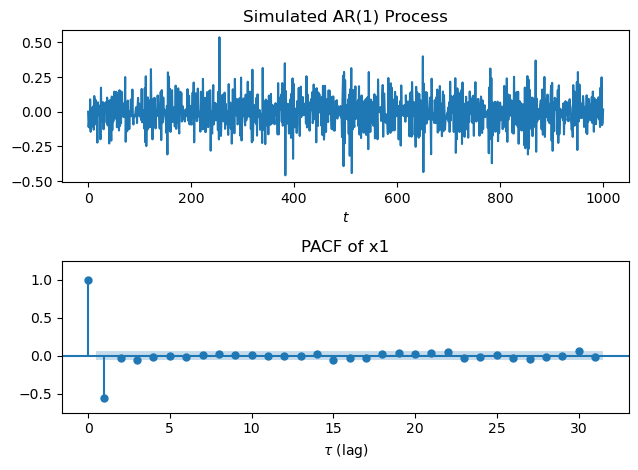

In [141]:
x1 = [0]
for i in range(1_000):
    x = -0.5*x1[-1] + 0.1*np.random.randn() # change from 0.5 to -0.5
    x1.append(x)
x1 = np.asarray(x1)

# plot
fig,ax = plt.subplots(nrows=2,ncols=1)

ax[0].plot(x1)
ax[0].set_xlabel(r'$t$')
ax[0].set_title('Simulated AR(1) Process')

# plot PACF
plot_pacf(x1,ax=ax[1])
ax[1].set_ylim(-0.75,1.25)
ax[1].set_title('PACF of x1')
ax[1].set_xlabel(r'$\tau$ (lag)')

fig.tight_layout()

- Now generate an AR(2) process, i.e the ts depends on two past values instead of just 1
    - Again the ts doesn't look much different from i.i.d noise
    - Looking at PACF. there are now two non-zero lags. These correspond to the two coefficients in the simulation. From the plot we would choose p = 2

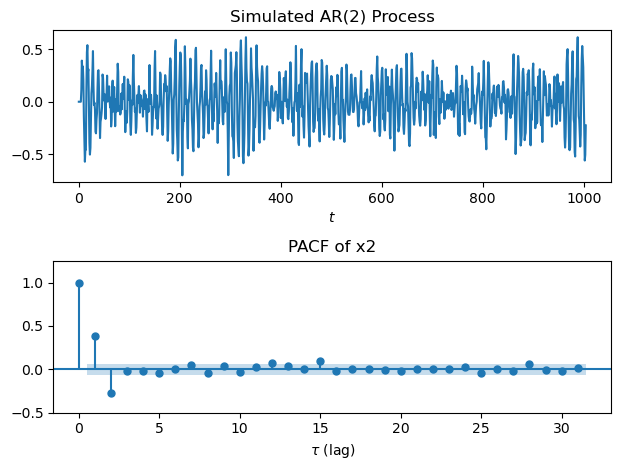

In [142]:
x2 = [0,0] # initialize

for i in range(1_000):
    x = 0.5*x2[-1] - 0.3*x2[-2] + 0.1*np.random.randn()
    x2.append(x)
x2 = np.asarray(x2)

# plot
fig,ax = plt.subplots(nrows=2,ncols=1)

ax[0].plot(x5)
ax[0].set_xlabel(r'$t$')
ax[0].set_title('Simulated AR(2) Process')

# plot PACF
plot_pacf(x2,ax=ax[1])
ax[1].set_ylim(-0.5,1.25)
ax[1].set_title('PACF of x2')
ax[1].set_xlabel(r'$\tau$ (lag)')

fig.tight_layout()

- Now simulate an AR(5) process
    - We'll make the series depend on only three values (not all of them), including the 5th previous value of course
    - From the ts plot, it definitely looks different from i.i.d noise and the previous simulated processes
- Plot PACF:
    - Even though our AR(5) process doesn't depend on lag 3 or 4 values, the PACF values at those lags are non-zero
    - When we fit an AR(p) model, if there are in-between values that don't affect the next value in a ts, it doesn't mean that their PACF values will be zero

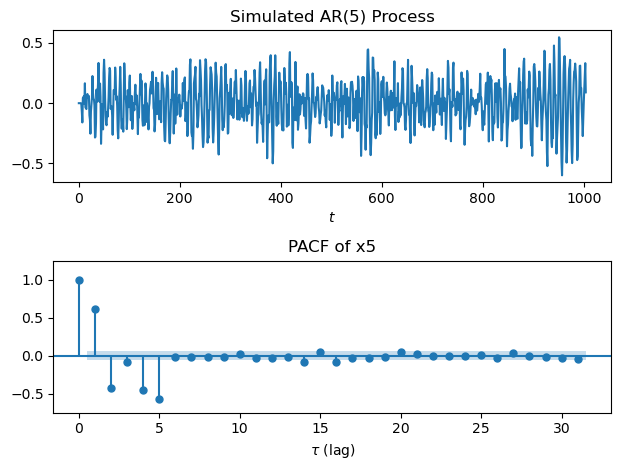

In [143]:
x5 = [0,0,0,0,0]
for i in range(1_000):
    x = 0.5*x5[-1] - 0.3*x5[-2] - 0.6*x5[-5] + 0.1*np.random.randn()
    x5.append(x)
x5 = np.asarray(x5)

# plot ts
fig,ax = plt.subplots(nrows=2,ncols=1)

ax[0].plot(x5)
ax[0].set_xlabel(r'$t$')
ax[0].set_title('Simulated AR(5) Process')

# plot PACF
plot_pacf(x5,ax=ax[1])
ax[1].set_ylim(-0.75,1.25)
ax[1].set_title('PACF of x5')
ax[1].set_xlabel(r'$\tau$ (lag)')

fig.tight_layout()

# ACF and MA(q) in Code
- Will use ACF to help choose MA(q)

In [144]:
from statsmodels.graphics.tsaplots import plot_acf

- As in previous section, start by plotting ACF for i.i.d noise:
    - As expected, there is no autocorrelation between any point and any other point in ts so ACF is zero (besides lag zero of course)

<Figure size 640x480 with 0 Axes>

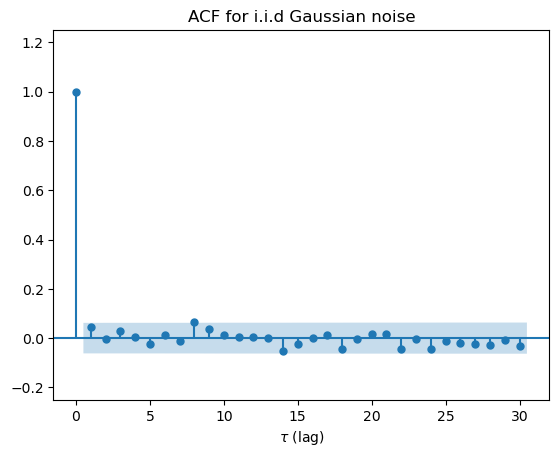

In [145]:
plt.figure()
plot_acf(np.random.randn(1_000))  # if lag parameter no specified then x axis goes like np.arange(len(corr))
plt.ylim(-0.25,1.25)
plt.title('ACF for i.i.d Gaussian noise')
plt.xlabel(r'$\tau$ (lag)')
plt.show()

- Now generate an MA(1) process:
    - The process is simulated by creating a series in which the next value depends on the error of the previous value plus some i.i.d noise
- Plot ACF:
    - As expected, there is a non-zero lag at tau = 1. So if we were to do this in reverse order, starting from the plot we would choose q = 1 for our MA model

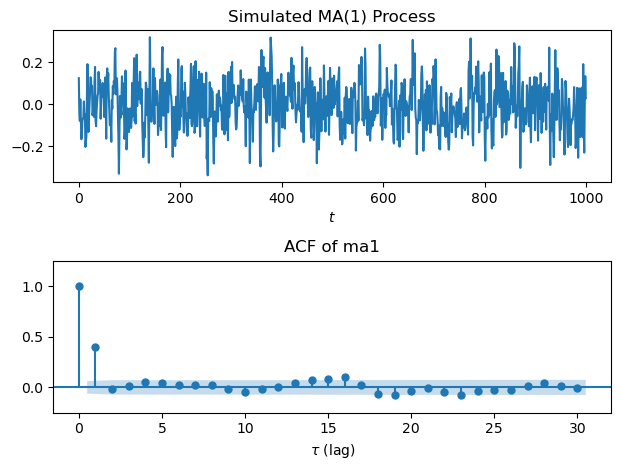

In [146]:
errors = 0.1*np.random.randn(1_000) # initialize 1000 samples from standard normal with std 0f 0.1
ma1 = []

for i in range(1_000): # same size as errors array
    if i>=1: # MA(1) equation
        x = + errors[i] + 0.5*errors[i-1] # sample is current error + coefficient * previous error
    else: # special case for first iteration (i=0) for which there is no past value
        x = errors[i]
    ma1.append(x)
ma1 = np.asarray(ma1)

# plot
fig,axes = plt.subplots(nrows=2,ncols=1)

axes[0].plot(ma1)
axes[0].set_xlabel(r'$t$')
axes[0].set_title('Simulated MA(1) Process')

plot_acf(ma1,ax=axes[1])
axes[1].set_ylim(-0.25,1.25)
axes[1].set_xlabel(r'$\tau$ (lag)')
axes[1].set_title('ACF of ma1')

fig.tight_layout()

- Next, generate an MA(2) process, i.e the ts depends on the error at lag 1 and at lag 2
- Plot ACF:
    - As expected, the maximum (latest) lag occurs for t = 2

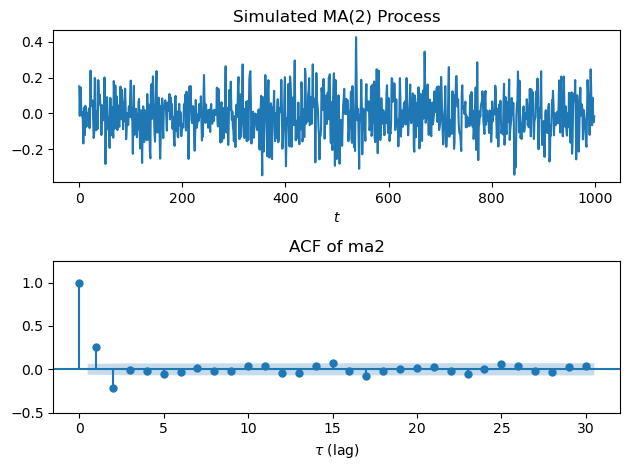

In [147]:
errors = 0.1*np.random.randn(1_000)
ma2 = []

for i in range(1_000):
    x = 0.5*errors[i-1] - 0.3*errors[i-2] + errors[i] # depends on two previous error values
    ma2.append(x) # no if/else needed bc the indices would be negative which gives a valid entry in the error array which is, of course, still random
ma2 = np.asarray(ma2)

# plot
fig,axes = plt.subplots(nrows=2,ncols=1)

axes[0].plot(ma2)
axes[0].set_xlabel(r'$t$')
axes[0].set_title('Simulated MA(2) Process')

plot_acf(ma2,ax=axes[1])
axes[1].set_ylim(-0.5,1.25)
axes[1].set_xlabel(r'$\tau$ (lag)')
axes[1].set_title('ACF of ma2')

fig.tight_layout()

- Now generate an MA(3) process
- Plot ACF:
    - Max (latest) non-zero lag is for tau = 3
    - Note that there are additional non-zero lags for greater tau's but we expect this to happen randomly about 5% of time (for default alpha = 0.05 C.I region)
    - E.g. we see additional non-zero lag at tau = 25 but we would still conclude that tau = 3 as we prefer the simpler model and former value is near C.I boundary anyways

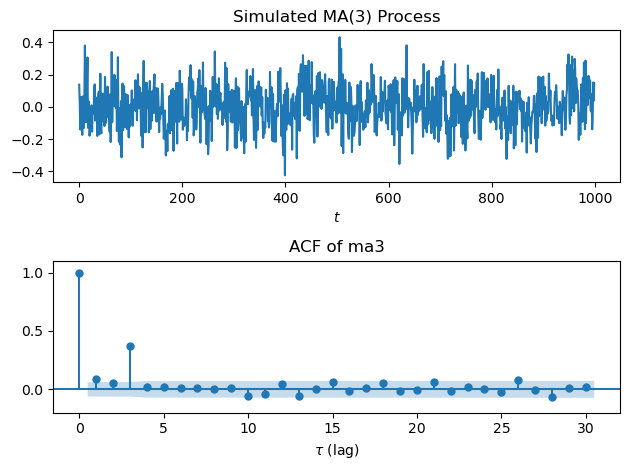

In [148]:
errors = 0.1*np.random.randn(1_000)
ma3 = []

for i in range(1_000):
    x = 0.5*errors[i-1] - 0.3*errors[i-2] + 0.7*errors[i-3] + errors[i] # depends on three previous error values
    ma3.append(x) # no if/else needed bc the indices would be negative which gives a valid entry in the error array which is, of course, still random
ma3 = np.asarray(ma3)

# plot
fig,axes = plt.subplots(nrows=2,ncols=1)

axes[0].plot(ma3)
axes[0].set_xlabel(r'$t$')
axes[0].set_title('Simulated MA(3) Process')

plot_acf(ma3,ax=axes[1])
axes[1].set_ylim(-0.2,1.1)
axes[1].set_xlabel(r'$\tau$ (lag)')
axes[1].set_title('ACF of ma3')

fig.tight_layout()

- Finally, simulate an MA(6) process
    - Note how the ts in plot doesn't look much different from all ts plotted before
- Plot ACF:
    - Note how at lag 4 the value is inside the C.I region. However, we would still choose tau = 6 as tau = 5 also has significantly high ACF

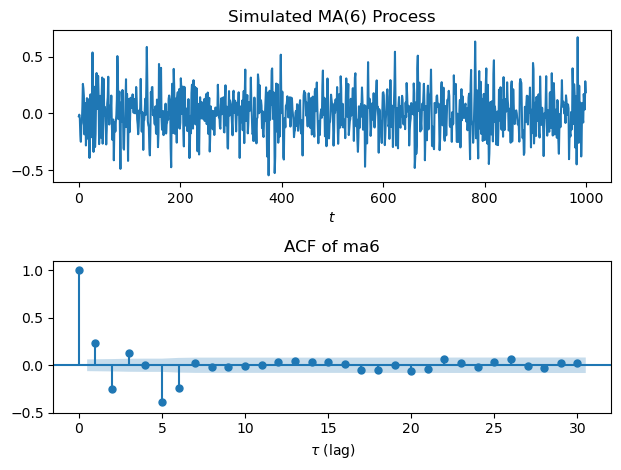

In [149]:
errors = 0.1*np.random.randn(1_000)
ma6 = []

for i in range(1_000):
    x = 0.5*errors[i-1] - 0.3*errors[i-2] + 0.7*errors[i-3] + \
        0.2*errors[i-4] - 0.8*errors[i-5] - 0.9*errors[i-6] + errors[i] # depends on six previous error values
    ma6.append(x) # no if/else needed bc the indices would be negative which gives a valid entry in the error array which is, of course, still random
ma6 = np.asarray(ma6)

# plot
fig,axes = plt.subplots(nrows=2,ncols=1)

axes[0].plot(ma6)
axes[0].set_xlabel(r'$t$')
axes[0].set_title('Simulated MA(6) Process')

plot_acf(ma6,ax=axes[1])
axes[1].set_ylim(-0.5,1.1)
axes[1].set_xlabel(r'$\tau$ (lag)')
axes[1].set_title('ACF of ma6')

fig.tight_layout()